# Colab Toy Model Test Workflow

In [2]:
import math
import os
from random import shuffle
import glob
import random 
import pandas as pd
import numpy as np

import cv2
import keras

from PIL import Image
from matplotlib import pyplot as plt
from skimage.io import imshow
from PIL import Image

from tensorflow.keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical


import segmentation_models as sm

import tensorflow as tf

from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.resnet50 import preprocess_input


# Segmentation Models
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.models import Model
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K


2023-12-12 11:27:43.025262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 11:27:44.428042: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 11:27:44.678586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64

Segmentation Models: using `keras` framework.


## Data loading 

In [4]:
# image and label directories paths
image_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"

In [3]:
#Image.open("/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397681372EDR_F0020000AUT_04096M1.JPG")


### Random visualization of overlapped image and label

In [5]:

edr_files = os.listdir(image_folder)
trlab_files = os.listdir(label_folder)

X = []
y = []
c = 0

# preparing X and y
for lab_name in trlab_files:
    img_name = lab_name[:-4] + ".JPG"
    
    if img_name in edr_files:
        
        img_path = os.path.join(image_folder, img_name)
        img_arr = cv2.imread(img_path)
        img_arr = cv2.resize(img_arr, dsize = (256, 256))
        
        lab_path = os.path.join(label_folder, lab_name)
        lab_arr = cv2.imread(lab_path, 0)
        lab_arr = cv2.resize(lab_arr, (256, 256), interpolation = cv2.INTER_NEAREST)
        
        X.append(img_arr)
        y.append(lab_arr)
        
    c += 1
    if c >= 100:
        break
        
X = np.asarray(X, dtype = np.float32) / 255.0
y = np.array(y, dtype = np.uint8)

# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)


# keeping integer values in labels will help us in segmentation task (UNet)
y[y==255] = 4

print(X.shape, y.shape)


(100, 256, 256, 3) (100, 256, 256)


In [5]:
"""
n = random.randint(0, len(X))
print(np.unique(y[n]))

plt.figure(figsize = (10, 10))

plt.imshow(X[n])
plt.imshow(y[n], alpha = 0.1)

plt.show()
"""

'\nn = random.randint(0, len(X))\nprint(np.unique(y[n]))\n\nplt.figure(figsize = (10, 10))\n\nplt.imshow(X[n])\nplt.imshow(y[n], alpha = 0.1)\n\nplt.show()\n'

In [10]:
y[98]

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 2, ..., 2, 2, 4],
       [4, 2, 2, ..., 2, 2, 4],
       ...,
       [4, 4, 2, ..., 2, 2, 4],
       [4, 4, 2, ..., 2, 2, 4],
       [4, 4, 4, ..., 2, 2, 4]], dtype=uint8)

In [7]:
#print(np.unique(y[255]))

In [8]:
# The 3 channels of each image are the same
#print(X[0][:,:,0])

In [9]:
#print(X[0][:,:,1])

In [10]:
#print(X[0][:,:,2])

### Build a customized data generator

In [30]:
# image and label directories paths
#dataset_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl"
image_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"


In [12]:
#img_names = sorted(os.listdir(image_folder))
#lab_names = sorted(os.listdir(label_folder))

In [13]:
#img_names[0]

'NLA_397586928EDR_F0010008AUT_04096M1.JPG'

In [14]:
#lab_names[1]

'NLA_397681339EDR_F0020000AUT_04096M1.png'

In [7]:
"""
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_folder, label_folder, input_shape, batch_size, num_classes, subfolder, split_percent):
        self.image_folder       = image_folder
        self.label_folder       = label_folder
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.subfolder          = subfolder
        self.split_percent      = split_percent
        self.path_df            = self.make_df()
        self.split_df()

    def __len__(self):
        print("Length of generator:", len(self.path_df))
        return math.ceil(len(self.path_df) / float(self.batch_size))
    
    def make_df(self):      
        img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
        lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]
        
        path_df = pd.DataFrame(columns=["image_path","label_path"])
        
        for label_name in lab_list:
            image_name = label_name.replace('.png', '.JPG')
            if image_name in img_list:
                path_df = path_df.append({
                    "image_path": os.path.join(self.image_folder, image_name),
                    "label_path": os.path.join(self.label_folder, label_name)
                }, ignore_index=True)
        return path_df
    
   
    
    def split_df(self):
        if self.subfolder == "train":
            self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]
        elif self.subfolder == "val":
            self.path_df = self.path_df.iloc[int(len(self.path_df) * self.split_percent):]
    
    
    def __getitem__(self, index):
        input_images  = []
        output_targets = []

        #-------------------------------#
        #   Calculate start indice and end indice of the batch
        #-------------------------------#  
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.path_df)) # Make sure that we can load all the data of the last batch

        for i in range(start, end):  
            
            #-------------------------------#
            #   Get image path and label path of each batch from path_df
            #-------------------------------#                     
            jpg = self.path_df.iloc[i]["image_path"]
            png = self.path_df.iloc[i]["label_path"]
                
            #-------------------------------#
            #   Transform images and labels to numpy array, resize them
            #   Set the background label to 4
            #-------------------------------#

            jpg = cv2.imread(jpg)           
            png = cv2.imread(png,0)
                
            jpg = cv2.resize(jpg, dsize = (int(self.input_shape[0]), int(self.input_shape[1])))
            png = cv2.resize(png, dsize = (int(self.input_shape[0]), int(self.input_shape[1])), 
                                      interpolation = cv2.INTER_NEAREST)

            png[png == 255] = 4

            #-------------------------------------------------------#
            #   One hot encode the labels
            #-------------------------------------------------------#
                
            seg_labels = np.eye(self.num_classes)[png.reshape([-1])]                
            seg_labels = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images = np.asarray(input_images)
        output_targets = np.array(output_targets)

        
        return input_images, output_targets
"""

In [ ]:
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_folder, label_folder, input_shape, batch_size, num_classes, subfolder, split_percent, use_mask = False):
        self.image_folder       = image_folder
        self.label_folder       = label_folder
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.subfolder          = subfolder
        self.split_percent      = split_percent
        self.path_df            = self.make_df()
        self.split_df()
        self.use_mask           = use_mask

    def __len__(self):
        print("Length of generator:", len(self.path_df))
        return math.ceil(len(self.path_df) / float(self.batch_size))
    
    import pdb
    pdb.set_trace()
    
    def make_df(self):      
        img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
        lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]
    
 
        path_df = pd.DataFrame(columns=["image_path", "label_path", "rover_mask_path", "range_mask_path"])

        for label_name in lab_list:
            image_name = label_name.replace('.png', '.JPG')
            rover_mask_name = label_name.replace('EDR', 'MXY')  
            range_mask_name = label_name.replace('EDR', 'RNG')  
            
            parent_folder = os.path.dirname(self.image_folder)
            rover_mask_path = os.path.join(parent_folder,'/mxy', rover_mask_name)
            range_mask_path = os.path.join(parent_folder,'rng-30m', range_mask_name)

            if image_name in img_list and os.path.exists(rover_mask_path) and os.path.exists(range_mask_path):
                path_df = path_df.append({
                    "image_path": os.path.join(self.image_folder, image_name),
                    "label_path": os.path.join(self.label_folder, label_name),
                    "rover_mask_path": os.path.join(parent_folder,'mxy', rover_mask_name),
                    "range_mask_path": os.path.join(parent_folder,'rng-30m', range_mask_name)
                }, ignore_index=True)
        return path_df

  
    
    def split_df(self):
        if self.subfolder == "train":
            self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]
        elif self.subfolder == "val":
            self.path_df = self.path_df.iloc[int(len(self.path_df) * self.split_percent):]
    
    
    def __getitem__(self, index):
        input_images  = []
        output_targets = []

        #-------------------------------#
        #   Calculate start indice and end indice of the batch
        #-------------------------------#  
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.path_df)) # Make sure that we can load all the data of the last batch

        for i in range(start, end):  
            
            #-------------------------------#
            #   Get image,label,rover mask and range mask path of each batch from path_df
            #-------------------------------#                     
            jpg = self.path_df.iloc[i]["image_path"]
            png = self.path_df.iloc[i]["label_path"]
            rover = self.path_df.iloc[i]["rover_mask_path"]
            rng = self.path_df.iloc[i]["range_mask_path"]
            
            #-------------------------------#
            #   Load both range and rover masks combined
            #-------------------------------#           
            rover_array = cv2.imread(rover)
            rng_array = cv2.imread(rng)
            # reversing mask to only keep the image out of the mask
            mask_combined = (1-rover_array) * (1-rng_array)
      
            #-------------------------------#
            #   Transform images and labels to numpy array, resize them
            #   Set the background label to 4
            #-------------------------------#

            jpg = cv2.imread(jpg)
            if self.use_mask:
                jpg = jpg * mask_combined            
            
            png = cv2.imread(png,0)
                
            jpg = cv2.resize(jpg, dsize = (int(self.input_shape[0]), int(self.input_shape[1])))
            png = cv2.resize(png, dsize = (int(self.input_shape[0]), int(self.input_shape[1])), 
                                      interpolation = cv2.INTER_NEAREST)

            png[png == 255] = 4

            #-------------------------------------------------------#
            #   One hot encode the labels
            #-------------------------------------------------------#
                
            seg_labels = np.eye(self.num_classes)[png.reshape([-1])]                
            seg_labels = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images = np.asarray(input_images)
        output_targets = np.array(output_targets)

        
        return input_images, output_targets

> /tmp/ipykernel_1069/2466099226.py(22)UnetDataGenerator()
     20     pdb.set_trace()
     21 
---> 22     def make_df(self):
     23         img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
     24         lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]

ipdb> img_list
*** NameError: name 'img_list' is not defined
ipdb> n
> /tmp/ipykernel_1069/2466099226.py(49)UnetDataGenerator()
     47 
     48 
---> 49     def split_df(self):
     50         if self.subfolder == "train":
     51             self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]

ipdb> n
> /tmp/ipykernel_1069/2466099226.py(56)UnetDataGenerator()
     54 
     55 
---> 56     def __getitem__(self, index):
     57         input_images  = []
     58         output_targets = []



In [16]:
                
            #mask_list = []
            #for n in range(0, self.num_classes ):  # Assurez-vous que les classes commencent à 0
            #    mask = (png == i).astype(np.float32)  # Crée un masque pour chaque classe
            #    mask_list.append(mask)

            ## Empilage des masques pour former 5 canaux
            #seg_labels = np.stack(mask_list, axis=-1)
                
            #import pdb
            #pdb.set_trace()

In [18]:
#lab_255 = os.path.join(dataset_path, "labels/train", lab_files[255])

In [19]:
#cv2.imread(lab_255).shape

In [20]:
#cv2.imread(lab_255,0).shape

In [21]:
#cv2.imread(lab_255,0).max()

In [22]:
#cv2.imread(lab_255,0).min()

In [23]:
#cv2.imread(lab_255,0).mean()

In [24]:
#np.unique(cv2.imread(lab_255,0))

In [25]:
#array_lab = cv2.imread(lab_255,0)

In [26]:
#resize_lab = cv2.resize(array_lab, dsize = (256, 256))

In [27]:
#resize_lab.max()

In [28]:
#lab_arr = cv2.resize(array_lab, (256, 256), interpolation = cv2.INTER_NEAREST)

In [29]:
#lab_arr.max()

In [30]:
#np.unique(lab_arr)

In [31]:
#lab_arr[lab_arr == 255] = 4

In [32]:
#lab_arr.max()

In [33]:
#np.unique(lab_arr)

In [34]:
#reshaped = png.reshape([-1])

In [35]:
#np.unique(reshaped)


In [36]:
#np.eye(4)[reshaped]

In [37]:
#png = cv2.imread(lab_255,0)

In [38]:
#np.unique(png)

In [39]:
#png_resize  = cv2.resize(png, dsize = (256,256))

In [40]:
#np.unique(png_resize)

In [41]:
#resize_2 = cv2.resize(png, dsize = (256,256),interpolation = cv2.INTER_NEAREST)

In [42]:
#np.unique(resize_2)

In [43]:
#resize_2[resize_2 == 255] = 4

In [44]:
#np.unique(resize_2)

In [45]:
#reshape_2 = resize_2.reshape([-1])

In [46]:
#np.unique(reshape_2)

In [47]:
#ohe = np.eye(5)[reshape_2]

In [48]:
#ohe.shape

In [49]:
#np.unique(ohe)

In [50]:
#ohe.reshape(256,256,5)

### Base Model building

In [23]:
def Unet_model():
    """
    Initialize the U-Net model
    """
    #################
    #    Params    #
    #################

    n_classes=5
    height=256
    width=256
    channels=3
    inputs = Input((height, width, channels))

    ############################
    # Down Sampling - Encoding #
    ############################

    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)

    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)

    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)

    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.1)(conv_4)
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)

    ############################
    #  Up Sampling - Decoding  #
    ############################

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    u6 = concatenate([u6, conv_4])
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    u7 = concatenate([u7, conv_3])
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    conv_7 = Dropout(0.1)(conv_7)
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    u8 = concatenate([u8, conv_2])
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    u9 = concatenate([u9, conv_1], axis=3)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)

    ################
    # Output Layer #
    ################

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)

    ########################
    # Model initialization #
    ########################

    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    
    return model

    

In [24]:
# Initializing and compiling model
model = Unet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[iou_score] )

2023-12-12 12:22:28.162982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-12-12 12:22:28.164002: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-12 12:22:28.164148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jinjin): /proc/driver/nvidia/version does not exist
2023-12-12 12:22:28.167462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

### ResNet_Backbone model

In [7]:
#%% pre-trained model

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
#x_train_new = preprocess_input(x_train)
#x_test_new = preprocess_input(x_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes, activation='softmax')

print(model_resnet_backbone.summary())

2023-12-10 07:26:11.468695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gargantua/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/../../lib64:
2023-12-10 07:26:11.469433: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-10 07:26:11.469459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Jinjin): /proc/driver/nvidia/version does not exist
2023-12-10 07:26:11.470292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropri

85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

 add_1 (Add)                    (None, None, None,   0           ['stage1_unit2_conv2[0][0]',     
                                64)                               'add[0][0]']                    
                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)       

                                                                                                  
 add_4 (Add)                    (None, None, None,   0           ['stage2_unit2_conv2[0][0]',     
                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padd

                                256)                                                              
                                                                                                  
 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
          

 add_10 (Add)                   (None, None, None,   0           ['stage3_unit4_conv2[0][0]',     
                                256)                              'add_9[0][0]']                  
                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)      

                                                                                                  
 add_13 (Add)                   (None, None, None,   0           ['stage4_unit1_conv2[0][0]',     
                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padd

 decoder_stage0b_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0b_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)    

                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, None, None,   4608        ['decoder_stage4_upsampling[0][0]
                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_s

In [12]:
# compile keras model with defined optimozer, loss and metrics

metrics=['accuracy', sm.metrics.iou_score]

#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=metrics)

### DeeplabV3 Model

In [36]:
NUM_CLASSES = 5
IMAGE_SIZE = 256

In [49]:
def convolution_block(
    block_input, 
    num_filters=256, 
    kernel_size=(3, 3), 
    dilation_rate=1, 
    padding="same", 
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters, 
        kernel_size=kernel_size, 
        dilation_rate=dilation_rate, 
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="nearest",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [50]:
# Use a ResNet50 pretrained on ImageNet as the backbone model
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="nearest",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="nearest",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


deep_model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
deep_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 256, 256, 3)  0          ['input_11[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 tf.nn.bias_add_3 (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.__operators__.getitem_3[0][0
                                                                 ]']                        

 conv2_block2_out (Activation)  (None, 64, 64, 256)  0           ['conv2_block2_add[0][0]']       
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16448       ['conv2_block2_out[0][0]']       
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_out (Activation)  (None, 32, 32, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 32, 32, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 16, 16, 1024  0           ['conv4_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block4_add (Add)         (None, 16, 16, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 16, 16, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 tf.nn.relu_2 (TFOpLambda)      (None, 16, 16, 256)  0           ['batch_normalization_4[0][0]']  
                                                                                                  
 tf.nn.relu_3 (TFOpLambda)      (None, 16, 16, 256)  0           ['batch_normalization_5[0][0]']  
                                                                                                  
 tf.nn.relu_4 (TFOpLambda)      (None, 16, 16, 256)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 concatenate_12 (Concatenate)   (None, 16, 16, 1280  0           ['up_sampling2d[0][0]',          
                                )                                 'tf.nn.relu_1[0][0]',           
                                                                  'tf.nn.relu_2[0][0]',           
          

In [52]:
loss = 'CategoricalCrossentropy'
metrics=['accuracy', iou_score]
deep_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=metrics,
)


In [55]:
MODEL = "DeepLab_Res50_ImageNet_img_256pix"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL),
                                            monitor="val_iou_score",
                                            save_best_only = False)

LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
                                         monitor="val_iou_score",
                                         factor = 0.1,
                                         min_lr = 0
                                        )

early_stopper = callbacks.EarlyStopping(patience = 5,
                                        monitor="val_iou_score",
                                        restore_best_weights=True)



deep_history = deep_model.fit(traingen,
          validation_data=valgen,
          epochs=100,
          callbacks = [modelCheckpoint, LR_reducer, early_stopper],
          verbose=1)

Length of generator: 3213
Length of generator: 12851
Length of generator: 12851
Length of generator: 12851
 88/804 [==>...........................] - ETA: 51:22 - loss: nan - iou_score: nan

KeyboardInterrupt: 

In [ ]:

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

### Creating Train and val data generator

In [53]:
# Split train and validation datasets
#X_train, X_test, y_train, y_test = train_test_split(#X,#y, output_targets, test_size = 0.2, random_state = 42)

In [54]:
#len(lab_names)

In [55]:
#len(img_names)

In [18]:
# Some inputs
#image_size = (256,256,3)
batch_size = 16
num_classes = 5
input_shape = (256,256,3)
split_percent = 0.8

In [9]:
# image and label directories paths
#dataset_path = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl"
image_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "/home/gargantua/code/TigerManon/08-Palette/ai4mars-dataset-merged-0.1/msl/labels/train"

In [21]:
# Train dataset generator and validation dataset generator
traingen = UnetDataGenerator(image_folder,
                             label_folder,
                             input_shape,                        
                             batch_size,
                             num_classes,
                             "train",
                             split_percent)

valgen = UnetDataGenerator(image_folder,
                           label_folder,
                           input_shape,                        
                           batch_size,
                           num_classes,
                           "val",
                           split_percent)


### Base Model Training

In [32]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(traingen,
          validation_data=valgen,
          epochs=1,
          callbacks=[es],
          verbose=1)  

Length of generator: 0
Length of generator: 0
Length of generator: 0


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [66]:
history.history

{'loss': [1.1562952995300293],
 'iou_score': [0.2526222765445709],
 'val_loss': [0.9600193500518799],
 'val_iou_score': [0.3342071771621704]}

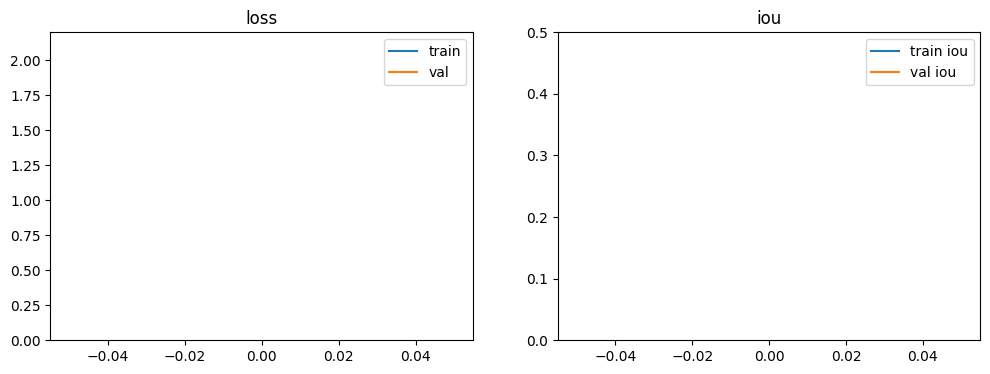

In [65]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
    ax2.set_ylim(0, 0.5)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()
    
plot_history(history)

### Pre-trained Model Training

In [13]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)

history_res_backbone=model_resnet_backbone.fit(traingen,
          validation_data=valgen,
          epochs=1,
          callbacks=[es],
          verbose=1)

Length of generator: 3213
Length of generator: 12851
Length of generator: 12851
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 0.7836 - accuracy: 0.7718 - iou_score: 0.4537Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 3224s 4s/step - loss: 0.7836 - accuracy: 0.7718 - iou_score: 0.4537 - val_loss: 1.1356 - val_accuracy: 0.5943 - val_iou_score: 0.3182
CPU times: user 4h 25min 40s, sys: 2min 35s, total: 4h 28min 16s
Wall time: 53min 44s


In [14]:
history_res_backbone.history

{'loss': [0.7836280465126038],
 'accuracy': [0.7717849016189575],
 'iou_score': [0.4537050127983093],
 'val_loss': [1.1355903148651123],
 'val_accuracy': [0.5942847728729248],
 'val_iou_score': [0.31823378801345825]}

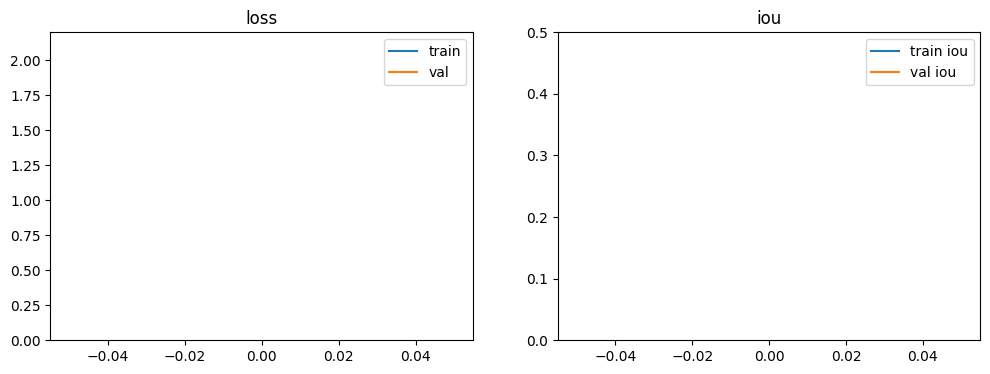

In [18]:
def plot_history(history_res_backbone, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history_res_backbone.history['loss'], label = 'train' + exp_name)
    ax1.plot(history_res_backbone.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history_res_backbone.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history_res_backbone.history['val_iou_score'], label='val iou'  + exp_name)
    ax2.set_ylim(0, 0.5)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()
    
plot_history(history_res_backbone)

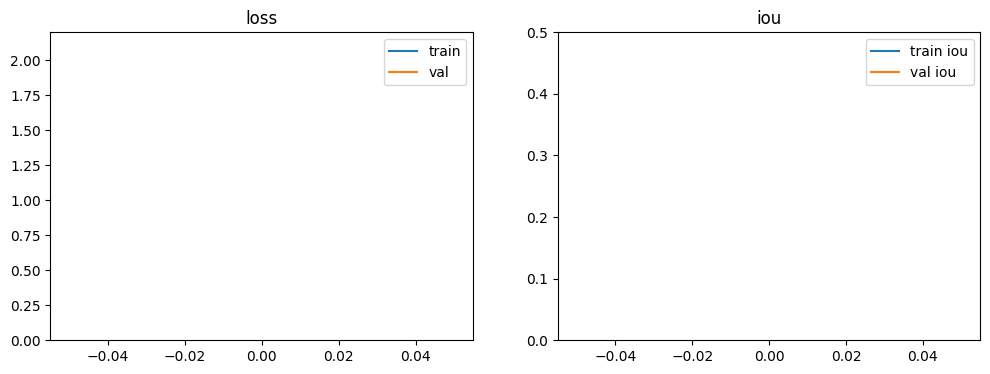

In [19]:
plot_history(history_res_backbone)

## Prediction

In [ ]:
 
# Load the image 
img = Image.open('cat.png') 
# Preprocess the image 
img = img.resize((256, 256)) 
img_array = image.img_to_array(img) 
img_array = np.expand_dims(img_array[:,:,:3], axis=0) 
img_array = img_array / 255.
  
# Load the model 
model = unet_model(input_shape=(256, 256, 3), num_classes=5) 
  
# Make predictions 
predictions = model.predict(img_array) 
  
# Convert predictions to a numpy array and resize to original image size 
predictions = np.squeeze(predictions, axis=0) 
predictions = np.argmax(predictions, axis=-1) 
predictions = Image.fromarray(np.uint8(predictions*255)) 
predictions = predictions.resize((img.width, img.height)) 
  
# Save the predicted image 
predictions.save('predicted_image.jpg') 
predictions

In [ ]:
def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):
    r""" The `Jaccard index`_, also known as Intersection over Union and the Jaccard similarity coefficient
    (originally coined coefficient de communauté by Paul Jaccard), is a statistic used for comparing the
    similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets,
    and is defined as the size of the intersection divided by the size of the union of the sample sets:

    .. math:: J(A, B) = \frac{A \cap B}{A \cup B}

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round

    Returns:
        IoU/Jaccard score in range [0, 1]

    .. _`Jaccard index`: https://en.wikipedia.org/wiki/Jaccard_index

    """

    backend = kwargs['backend']

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


In [ ]:
import numpy as np

def iou_score(pred_mask, true_mask):
    """
    
    :param pred_mask:  (height, width, num_classes)
    :param true_mask:  (height, width, num_classes)
    :return: IOU of each class
    """
    ious = []
    for c in range(pred_mask.shape[-1]): 

        pred_c = pred_mask[..., c]
        true_c = true_mask[..., c]

        intersection = np.logical_and(pred_c, true_c)
        union = np.logical_or(pred_c, true_c)

        # 计算 IOU
        if np.sum(union) == 0:
            iou = 0
        else:
            iou = np.sum(intersection) / np.sum(union)

        ious.append(iou)
    
    return ious


In [ ]:

iou_scores = iou_score(pred_mask, true_mask)

for i, iou in enumerate(iou_scores):
    print(f"Class {i} IOU Score: {iou}")


In [ ]:
import numpy as np

def mean_iou_score(pred_mask, true_mask):
    """
   :param pred_mask:  (height, width, num_classes)
    :param true_mask:  (height, width, num_classes)
    :return: IOU of all classes
    """
    total_intersection = 0
    total_union = 0
    
    for c in range(pred_mask.shape[-1]):  
        
        pred_c = pred_mask[..., c]
        true_c = true_mask[..., c]

        intersection = np.logical_and(pred_c, true_c)
        union = np.logical_or(pred_c, true_c)

        total_intersection += np.sum(intersection)
        total_union += np.sum(union)

    if total_union == 0:

        mean_iou = 0
    else:
        mean_iou = total_intersection / total_union
    
    return mean_iou


In [ ]:
import numpy as np

def one_hot_encode(mask, num_classes):
    """
    将单通道的类别掩码转换为多通道的二进制形式。
    
    :param mask: 单通道掩码，每个像素值代表类别编号
    :param num_classes: 类别总数
    :return: 多通道的二进制掩码
    """
    return np.eye(num_classes)[mask]

def mean_iou_score(pred_mask, true_mask, num_classes):
    """
    计算预测掩码和真实掩码之间的平均 IOU 分数。
    
    :param pred_mask: 预测掩码，单通道，每个像素值代表类别编号
    :param true_mask: 真实掩码，单通道，每个像素值代表类别编号
    :param num_classes: 类别总数
    :return: 所有类别的平均 IOU 分数
    """
    # 将单通道掩码转换为多通道二进制形式
    pred_mask_one_hot = one_hot_encode(pred_mask, num_classes)
    true_mask_one_hot = one_hot_encode(true_mask, num_classes)

    total_intersection = 0
    total_union = 0

    for c in range(num_classes):  # 遍历每个类别
        pred_c = pred_mask_one_hot[..., c]
        true_c = true_mask_one_hot[..., c]

        intersection = np.logical_and(pred_c, true_c)
        union = np.logical_or(pred_c, true_c)

        total_intersection += np.sum(intersection)
        total_union += np.sum(union)

    if total_union == 0:
        mean_iou = 0
    else:
        mean_iou = total_intersection / total_union
    
    return mean_iou
